In [1]:
import importlib
import os
import more_itertools

#plotting imports
from tkinter import CENTER
import matplotlib.pyplot as plt

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyRandomForestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

# Pokemon Battle Predictor
### By Greeley Lindberg and Emily Inkrott

## Introduction
*This section must briefly describe the dataset you used and the classification task you implemented (e.g., what were you trying to classify in the dataset). You should also briefly describe your findings (e.g., what classifier approach performed the best).*

For our project, we worked with a **Pokemon battle dataset**. Looking at a list of Pokemon matchups, **we attempted to determine which Pokemon would win the battle** based on their individual charictaristics, similar to the PA7 basketball classification task.

## Data Analysis

Our dataset initially consisted of three different csv files: `combats.csv`, which had a list of matchups between two pokemon and the winner for each battle, `pokemon.csv`, which listed information on every pokemon in `combats.csv`, and a third csv file containing a testing set, which was not used in the project. We combined `pokemon.csv` and `combats.csv` into `pokemon_combats.csv` for our exploratory data analysis and inital classifier performance analysis. Later, we decided that calculating advantages would give us better results than using individual stat values, leading to the creation of `pokemon_combats_advantage.csv`.

**Our dataset has 50,000 instances and 19 attributes**.

The following attributes are in `pokemon_combats_advantage.csv`:
1. **First_pokemon**: the ID number of the first battler
2. **Name_first**: the name of the first battler
3. **Type_1_first**: the primary type of the first battler
4. **Type_2_first**: the primary type of the second battler
5. **Generation_first**: the generation of Pokemon games that the first battler was introduced in
6. **Legendary_first**: whether or not the first battler is a legendary Pokemon
7. **Second_pokemon, Name_second, Type 1_second, Type 2_second, Generation_second, Legendary_second**, which are all the same as their "first" counterparts, but for the second battler
8. **HP**: which Pokemon has the higher HP stat (either 1 or 2)
9. **Attack**: which Pokemon has the higher attack stat (either 1 or 2)
10. **Defense**: which Pokemon has the higher defense stat (either 1 or 2)
10. **Sp. Atk**: which Pokemon has the higher special attack stat (either 1 or 2)
10. **Sp. Def**: which Pokemon has the higher special defense stat (either 1 or 2)
10. **Speed**: which Pokemon has the higher speed stat (either 1 or 2)
10. **Winner**: which Pokemon won the battle. **This is our class label.**

In [2]:
filename = os.path.join("input_data", "pokemon_combats.csv")
combats_filename = os.path.join("input_data", "combats.csv")
pokemon_filename = os.path.join("input_data", "pokemon.csv")

pokemon_table = MyPyTable().load_from_file(pokemon_filename)
combats_filename = MyPyTable().load_from_file(combats_filename)
table = MyPyTable().load_from_file(filename)



During our initial EDA, we looked at several attributes to see how they might correlate with win rates. **We discovered two main indicators of who would win the battle: type, and speed.** These charts can be found in `EDA.ipynb` and have been reproduced below. 

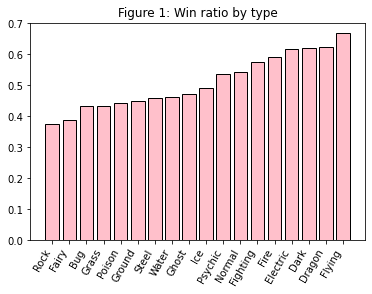

In [3]:
primary_type_vals, primary_type_counts = myutils.get_frequencies_by_col_name(pokemon_table.data, pokemon_table.column_names, "Type 1")
secondary_type_vals, secondary_type_counts = myutils.get_frequencies_by_col_name(pokemon_table.data, pokemon_table.column_names, "Type 2")

#add frequencies to get the total number of apperances by type
for i in range(len(secondary_type_vals)):
    if secondary_type_vals[i] in primary_type_vals:
        p_index = primary_type_vals.index(secondary_type_vals[i])
        primary_type_counts[p_index] += secondary_type_counts[i]


s_counts, s_types = more_itertools.sort_together([primary_type_counts, primary_type_vals])

winners = []
losers = []
type_counts = [0 for instance in s_types]
type_indexes = [5, 6, 17, 18]
winners_header = pokemon_table.column_names.copy()
for instance in table.data:
    curr_winner = []
    curr_loser = []
    if instance[2] == 1:
        curr_winner.extend(instance[3:15])
        curr_loser.extend(instance[15:])
    else:
        curr_winner.extend(instance[15:])
        curr_loser.extend(instance[3:15])
    winners.append(curr_winner)
    losers.append(curr_loser)
    #types are stored at 5, 6, 17, 18 
    for index in type_indexes:
        type = instance[index]
        if type != '':
            type_counts[s_types.index(type)] += 1

winner_type_vals, winner_type_counts = myutils.get_frequencies_by_col_name(winners, winners_header, "Type 1")
w_secondary_type_vals, w_secondary_type_counts = myutils.get_frequencies_by_col_name(winners, winners_header, "Type 2")

#add frequencies to get the total number of apperances by type
for i in range(len(w_secondary_type_vals)):
    if w_secondary_type_vals[i] in winner_type_vals:
        p_index = winner_type_vals.index(w_secondary_type_vals[i])
        winner_type_counts[p_index] += w_secondary_type_counts[i]
w_ratios = []
for i in range(len(winner_type_vals)):
    #s_types parallel to type_counts
    w_ratios.append(winner_type_counts[i]/type_counts[s_types.index(winner_type_vals[i])])

w_rates, w_types, w_counts = more_itertools.sort_together([w_ratios, winner_type_vals, winner_type_counts])

plt.figure()
plt.bar(w_types, w_rates, align= CENTER, edgecolor='black', color = 'pink')
plt.xticks(w_types, w_types, rotation = 60, ha="right")
plt.title("Figure 1: Win ratio by type")
plt.show()

As shown by figure 1, different types had win ratios varying by as much as 30%. **Dragon, Flying, and Dark types had the highest win ratios, while Rock, Fairy, and Bug types had the lowest.**

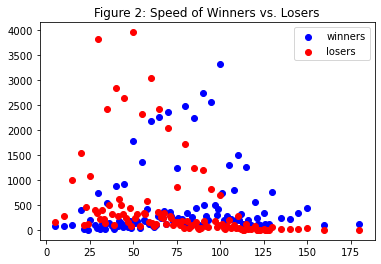

In [4]:
stat_header = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
stat_table = myutils.get_columns(winners, winners_header, stat_header)
loser_stat_table =  myutils.get_columns(losers, winners_header, stat_header)
    
stat_vals, stat_freqs = myutils.get_frequencies_by_col_name(stat_table, stat_header, "Speed")
loser_vals, loser_freqs = myutils.get_frequencies_by_col_name(loser_stat_table, stat_header, "Speed")
plt.title("Figure 2: Speed of Winners vs. Losers")
plt.scatter(stat_vals, stat_freqs, color="blue", label="winners")
plt.scatter(loser_vals, loser_freqs, color="red", label="losers")
plt.legend()
plt.show()

Speed was the only stat that showed significant differences between battle winners and losers. As shown by figure 2, **battle winners noticeably tended to have a higher speed stat, while battle losers had lower ones.** Attack and special defense also had slight variation where winners tended to have higher stats than losers, but the difference was far less significant.

# Classification Results

In our initial classification, seen in `classifier_performance.ipynb`, we used the classifiers constructed throughout the semester on Pokemon types and stats to make predictions. 

## Setup

In [5]:
# pokemon type
type_1_first = table.get_column("Type 1_first")
type_2_first = table.get_column("Type 2_first")
type_1_second = table.get_column("Type 1_second")
type_2_second = table.get_column("Type 2_second")
X_types = [[t1f, t2f, t1s, t2s] for t1f, t2f, t1s, t2s in zip(type_1_first, type_2_first, type_1_second, type_2_second)]
y = table.get_column("Winner")
train_sets_types, test_sets_types = myevaluation.stratified_kfold_cross_validation(X_types, y, n_splits=10, random_state=0, shuffle=False)

In [6]:
nb = MyNaiveBayesClassifier()
dummy = MyDummyClassifier()
dt = MyDecisionTreeClassifier()
rf = MyRandomForestClassifier(N=5, M=3, F=3)

# accuracy is the total correctly predicted divided by the total predicted over all the folds
knn_correct, nb_correct, dummy_correct, dt_correct, rf_correct, total_predicted = 0, 0, 0, 0, 0, 0
knn_preds, nb_preds, dummy_preds, dt_preds, rf_preds, y_true = [], [], [], [], [], []

for train, test in zip(train_sets_types, test_sets_types):
    X_train = [X_types[i] for i in train]
    y_train = [y[i] for i in train]
    X_test = [X_types[i] for i in test]
    y_test = [y[i] for i in test]
    total_predicted += len(y_test)
    y_true += y_test

    # Naive Bayes
    nb.fit(X_train, y_train)
    nb_pred = nb.predict(X_test)
    nb_preds += nb_pred
    nb_correct += myevaluation.accuracy_score(y_test, nb_pred, normalize=False)

    # Dummy
    dummy.fit(X_train, y_train)
    dummy_pred = dummy.predict(X_test)
    dummy_preds += dummy_pred
    dummy_correct += myevaluation.accuracy_score(y_test, dummy_pred, normalize=False)

    # Decision Tree
    dt.fit(X_train, y_train)
    dt_pred = dt.predict(X_test)
    dt_preds += dt_pred
    dt_correct += myevaluation.accuracy_score(y_test, dt_preds, normalize=False)

    # Random Forest
    rf.fit(X_train, y_train)
    rf.pred = rf.predict(X_test)
    rf_preds += rf.pred
    rf_correct += myevaluation.accuracy_score(y_test, rf_preds, normalize=False)


## Classifier Perfomance Using Pokemon Typings


### Naive Bayes

In [7]:
labels = [1, 2]
pos_label = 1
header = ["Winner", "1", "2"]

nb_accuracy = nb_correct / total_predicted
nb_precision = myevaluation.binary_precision_score(y_true, nb_preds, labels=labels, pos_label=pos_label)
nb_recall = myevaluation.binary_recall_score(y_true, nb_preds, labels=labels, pos_label=pos_label)
nb_f1 = myevaluation.binary_f1_score(y_true, nb_preds, labels=labels, pos_label=pos_label)
nb_confusion_matrix = myevaluation.confusion_matrix(y_true, nb_preds, labels)

myutils.print_results("Naive Bayes Classifier", nb_accuracy, nb_precision, nb_recall, nb_f1)
myutils.print_confusion_matrix(header, nb_confusion_matrix, labels)


Naive Bayes Classifier
accuracy score: 0.615
error rate: 0.385
precision score: 0.602
recall score: 0.546
f1 score: 0.573

  Winner      1      2    Total    Recognition (%)
--------  -----  -----  -------  -----------------
       1  12886  10715    23601             54.599
       2   8515  17884    26399             67.745


### Dummy

In [8]:
dummy_accuracy = dummy_correct / total_predicted
dummy_precision = myevaluation.binary_precision_score(y_true, dummy_preds, labels=labels, pos_label=pos_label)
dummy_recall = myevaluation.binary_recall_score(y_true, dummy_preds, labels=labels, pos_label=pos_label)
dummy_f1 = myevaluation.binary_f1_score(y_true, dummy_preds, labels=labels, pos_label=pos_label)
dummy_confusion_matrix = myevaluation.confusion_matrix(y_true, dummy_preds, labels)

myutils.print_results("Dummy Classifier", dummy_accuracy, dummy_precision, dummy_recall, dummy_f1)
myutils.print_confusion_matrix(header, dummy_confusion_matrix, labels)


Dummy Classifier
accuracy score: 0.472
error rate: 0.528
precision score: 0.22
recall score: 0.047
f1 score: 0.077

  Winner     1      2    Total    Recognition (%)
--------  ----  -----  -------  -----------------
       1  1101  22500    23601              4.665
       2  3899  22500    26399             85.231


### Decision Tree

In [9]:
dt_accuracy = dt_correct / total_predicted
dt_precision = myevaluation.binary_precision_score(y_true, dt_preds, labels=labels, pos_label=pos_label)
dt_recall = myevaluation.binary_recall_score(y_true, dt_preds, labels=labels, pos_label=pos_label)
dt_f1 = myevaluation.binary_f1_score(y_true, dt_preds, labels=labels, pos_label=pos_label)
dt_confusion_matrix = myevaluation.confusion_matrix(y_true, dt_preds, labels)

myutils.print_results("Decision Tree Classifier", dt_accuracy, dt_precision, dt_recall, dt_f1)
myutils.print_confusion_matrix(header, dt_confusion_matrix, labels)


Decision Tree Classifier
accuracy score: 0.515
error rate: 0.485
precision score: 0.456
recall score: 0.295
f1 score: 0.358

  Winner     1      2    Total    Recognition (%)
--------  ----  -----  -------  -----------------
       1  6966  16635    23601             29.516
       2  8303  18096    26399             68.548


### Random Forest

In [10]:
rf_accuracy = dt_correct / total_predicted
rf_precision = myevaluation.binary_precision_score(y_true, rf_preds, labels=labels, pos_label=pos_label)
rf_recall = myevaluation.binary_recall_score(y_true, rf_preds, labels=labels, pos_label=pos_label)
rf_f1 = myevaluation.binary_f1_score(y_true, rf_preds, labels=labels, pos_label=pos_label)
rf_confusion_matrix = myevaluation.confusion_matrix(y_true, rf_preds, labels)

myutils.print_results("Random Forest Classifier", rf_accuracy, rf_precision, rf_recall, rf_f1)
myutils.print_confusion_matrix(header, rf_confusion_matrix, labels)


Random Forest Classifier
accuracy score: 0.515
error rate: 0.485
precision score: 0.427
recall score: 0.083
f1 score: 0.139

  Winner     1      2    Total    Recognition (%)
--------  ----  -----  -------  -----------------
       1  1955  21646    23601              8.284
       2  2628  23771    26399             90.045


## Classifier Performance Based on Pokemon Statistics

### Setup

In [14]:
# pokemon stats
filename = os.path.join("input_data", "pokemon_combats_advantage.csv")
new_table = MyPyTable().load_from_file(filename)
speed = new_table.get_column("Speed")
attack = new_table.get_column("Attack")
defense = new_table.get_column("Defense")
sp_attack = new_table.get_column("Sp. Atk")
sp_defense = new_table.get_column("Sp. Def")
X_stats = [[s, a, d, sa, sd] for s, a, d, sa, sd in zip(speed, attack, defense, sp_attack, sp_defense)]
y = new_table.get_column("Winner")
train_sets_types, test_sets_types = myevaluation.stratified_kfold_cross_validation(X_stats, y, n_splits=10, random_state=0, shuffle=False)

In [15]:
nb = MyNaiveBayesClassifier()
dummy = MyDummyClassifier()
dt = MyDecisionTreeClassifier()
rf = MyRandomForestClassifier(N=5, M=3, F=3)

# accuracy is the total correctly predicted divided by the total predicted over all the folds
knn_correct, nb_correct, dummy_correct, dt_correct, rf_correct, total_predicted = 0, 0, 0, 0, 0, 0
knn_preds, nb_preds, dummy_preds, dt_preds, rf_preds, y_true = [], [], [], [], [], []

for train, test in zip(train_sets_types, test_sets_types):
    X_train = [X_types[i] for i in train]
    y_train = [y[i] for i in train]
    X_test = [X_types[i] for i in test]
    y_test = [y[i] for i in test]
    total_predicted += len(y_test)
    y_true += y_test

    # Naive Bayes
    nb.fit(X_train, y_train)
    nb_pred = nb.predict(X_test)
    nb_preds += nb_pred
    nb_correct += myevaluation.accuracy_score(y_test, nb_pred, normalize=False)

    # Dummy
    dummy.fit(X_train, y_train)
    dummy_pred = dummy.predict(X_test)
    dummy_preds += dummy_pred
    dummy_correct += myevaluation.accuracy_score(y_test, dummy_pred, normalize=False)

    # Decision Tree
    dt.fit(X_train, y_train)
    dt_pred = dt.predict(X_test)
    dt_preds += dt_pred
    dt_correct += myevaluation.accuracy_score(y_test, dt_preds, normalize=False)

    # Random Forest
    rf.fit(X_train, y_train)
    rf.pred = rf.predict(X_test)
    rf_preds += rf.pred
    rf_correct += myevaluation.accuracy_score(y_test, rf_preds, normalize=False)

### Naive Bayes

In [16]:
labels = [1, 2]
pos_label = 1
header = ["Winner", "1", "2"]

nb_accuracy = nb_correct / total_predicted
nb_precision = myevaluation.binary_precision_score(y_true, nb_preds, labels=labels, pos_label=pos_label)
nb_recall = myevaluation.binary_recall_score(y_true, nb_preds, labels=labels, pos_label=pos_label)
nb_f1 = myevaluation.binary_f1_score(y_true, nb_preds, labels=labels, pos_label=pos_label)
nb_confusion_matrix = myevaluation.confusion_matrix(y_true, nb_preds, labels)

myutils.print_results("Naive Bayes Classifier", nb_accuracy, nb_precision, nb_recall, nb_f1)
myutils.print_confusion_matrix(header, nb_confusion_matrix, labels)


Naive Bayes Classifier
accuracy score: 0.615
error rate: 0.385
precision score: 0.602
recall score: 0.546
f1 score: 0.573

  Winner      1      2    Total    Recognition (%)
--------  -----  -----  -------  -----------------
       1  12886  10715    23601             54.599
       2   8515  17884    26399             67.745


### Dummy

In [17]:
dummy_accuracy = dummy_correct / total_predicted
dummy_precision = myevaluation.binary_precision_score(y_true, dummy_preds, labels=labels, pos_label=pos_label)
dummy_recall = myevaluation.binary_recall_score(y_true, dummy_preds, labels=labels, pos_label=pos_label)
dummy_f1 = myevaluation.binary_f1_score(y_true, dummy_preds, labels=labels, pos_label=pos_label)
dummy_confusion_matrix = myevaluation.confusion_matrix(y_true, dummy_preds, labels)

myutils.print_results("Dummy Classifier", dummy_accuracy, dummy_precision, dummy_recall, dummy_f1)
myutils.print_confusion_matrix(header, dummy_confusion_matrix, labels)


Dummy Classifier
accuracy score: 0.472
error rate: 0.528
precision score: 0.22
recall score: 0.047
f1 score: 0.077

  Winner     1      2    Total    Recognition (%)
--------  ----  -----  -------  -----------------
       1  1101  22500    23601              4.665
       2  3899  22500    26399             85.231


### Decsion Tree

In [19]:
dt_accuracy = dt_correct / total_predicted
dt_precision = myevaluation.binary_precision_score(y_true, dt_preds, labels=labels, pos_label=pos_label)
dt_recall = myevaluation.binary_recall_score(y_true, dt_preds, labels=labels, pos_label=pos_label)
dt_f1 = myevaluation.binary_f1_score(y_true, dt_preds, labels=labels, pos_label=pos_label)
dt_confusion_matrix = myevaluation.confusion_matrix(y_true, dt_preds, labels)

myutils.print_results("Decision Tree Classifier", dt_accuracy, dt_precision, dt_recall, dt_f1)
myutils.print_confusion_matrix(header, dt_confusion_matrix, labels)


Decision Tree Classifier
accuracy score: 0.515
error rate: 0.485
precision score: 0.456
recall score: 0.295
f1 score: 0.358

  Winner     1      2    Total    Recognition (%)
--------  ----  -----  -------  -----------------
       1  6966  16635    23601             29.516
       2  8303  18096    26399             68.548


### Random Forest

In [21]:
rf_accuracy = rf_correct / total_predicted
rf_precision = myevaluation.binary_precision_score(y_true, rf_preds, labels=labels, pos_label=pos_label)
rf_recall = myevaluation.binary_recall_score(y_true, rf_preds, labels=labels, pos_label=pos_label)
rf_f1 = myevaluation.binary_f1_score(y_true, rf_preds, labels=labels, pos_label=pos_label)
rf_confusion_matrix = myevaluation.confusion_matrix(y_true, rf_preds, labels)

myutils.print_results("Random Forest Classifier", rf_accuracy, rf_precision, rf_recall, rf_f1)
myutils.print_confusion_matrix(header, rf_confusion_matrix, labels)


Random Forest Classifier
accuracy score: 0.515
error rate: 0.485
precision score: 0.427
recall score: 0.083
f1 score: 0.139

  Winner     1      2    Total    Recognition (%)
--------  ----  -----  -------  -----------------
       1  1955  21646    23601              8.284
       2  2628  23771    26399             90.045
